# Machine Learning - Prof: Lívia Almada

* **Equipe:** Henricky de Lima Monteiro (475075) & Danilo Carneiro ()

In [1]:
#importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
import xgboost as xgb
import json
from pprint import pprint

Este trabalho tem por objetivo analisar quais eventos influênciam no resultado de uma partida rankeado do jogo League of Legends(LOL), jogo do estilo MOBA onde duas equipes de 5 campeões que se enfrentam em 3 rotas e um intermédio delas, chamada *jungle*. Uma partida de Lol tem por objetivo destruir torres para acessar a base e destruir o centro da mesma (Nexus). Durante o desenvolvimento deste trabalho nos deparamos com as seguintes dúvida:

* **Pré-game:** Existem fatores durante a seleção de campeões que influênciam na vítória? (como os campeões selecionados, bans e feitiços de invocador)
* **in-game:** Fatores como quem pegou "first_blood", torres e 
* 

## Lendo dados do DataSet

In [2]:
# Leitura dos Dataset
df = pd.read_csv("games.csv")
print(df.shape)


(51490, 61)


### DataSet Pre Partida

In [3]:
#filtragem das colunas necessárias
labels_desejadas = [
    'winner', 't1_champ1id', 't1_champ1_sum1', 't1_champ1_sum2', 't1_champ2id', 't1_champ2_sum1',
    't1_champ2_sum2', 't1_champ3id', 't1_champ3_sum1', 't1_champ3_sum2', 't1_champ4id', 't1_champ4_sum1',
    't1_champ4_sum2', 't1_champ5id', 't1_champ5_sum1', 't1_champ5_sum2', 't1_ban1', 't1_ban2', 't1_ban3',
    't1_ban4', 't1_ban5', 't2_champ1id', 't2_champ1_sum1', 't2_champ1_sum2', 't2_champ2id', 't2_champ2_sum1',
    't2_champ2_sum2', 't2_champ3id', 't2_champ3_sum1', 't2_champ3_sum2', 't2_champ4id', 't2_champ4_sum1',
    't2_champ4_sum2', 't2_champ5id', 't2_champ5_sum1', 't2_champ5_sum2', 't2_ban1', 't2_ban2', 't2_ban3',
    't2_ban4', 't2_ban5', 'gameDuration'
]

df = df[labels_desejadas]
df.shape

(51490, 42)

In [4]:
df = df.fillna(0)
df

,winner,t1_champ1id,t1_champ1_sum1,t1_champ1_sum2,t1_champ2id,t1_champ2_sum1,t1_champ2_sum2,t1_champ3id,t1_champ3_sum1,t1_champ3_sum2,...,t2_champ4_sum2,t2_champ5id,t2_champ5_sum1,t2_champ5_sum2,t2_ban1,t2_ban2,t2_ban3,t2_ban4,t2_ban5,gameDuration
0,1,8,12,4,432,3,4,96,4,7,...,4,412,4,3,114,67,43,16,51,1949
1,1,119,7,4,39,12,4,76,4,3,...,14,92,4,7,11,67,238,51,420,1851
2,1,18,4,7,141,11,4,267,3,4,...,11,22,7,4,157,238,121,57,28,1493
3,1,57,4,12,63,4,14,29,4,7,...,14,22,4,7,164,18,141,40,51,1758
4,1,19,4,12,29,11,4,40,4,3,...,12,51,4,7,86,11,201,122,18,2094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51485,2,19,12,4,429,4,7,91,4,14,...,4,79,11,4,55,-1,90,238,157,1944
51486,2,90,4,14,32,4,11,31,12,4,...,12,45,14,4,157,55,119,154,105,3304
51487,2,141,11,4,18,7,4,432,3,4,...,4,99,14,4,113,122,53,11,157,2156
51488,2,121,11,4,236,4,7,420,4,12,...,4,11,11,4,154,39,51,90,114,1475


### Lendo os Dados do Arquivos auxiliares

* summoner_spell_info.json
* champion_info_2.json

In [18]:
if(False): # Código para gerar 'champions_info_modified'
    champions_info_df = pd.read_json('champions_info_modified.json')
    # print(champions_info_df.head())
    # print(summoner_spell_info_df.head())
    champions_info_df = champions_info_df['data'] 
    champions_info_transposed = champions_info_df.transpose()
    print(champions_info_transposed)
    # Lendo o arquivo summoner_spell_info.json
    summoner_spell_info_df = pd.read_json('summoner_spell_info.json')

#### Leitura dos Dados de Campeão

In [5]:
with open('champions_info_modified.json') as file:
    champions_data = json.load(file)

In [10]:
# Vetorização das tags de campeões para cada time e campeão
for team in ['t1', 't2']:
    for champ in range(1, 6):
        champ_id_col = f'{team}_champ{champ}id'
        champ_tags_col = f'{team}_champ{champ}_tags'

        df[champ_tags_col] = df[champ_id_col].map(lambda x: champions_data['data'][str(int(x))]['tags'] if pd.notnull(x) else None)

        # Vetorização one-hot para as tags de campeões
        champ_tags_encoded = pd.get_dummies(df[champ_tags_col].apply(pd.Series).stack()).sum(level=0)
        champ_tags_encoded = champ_tags_encoded.add_prefix(f'{champ_tags_col}_')

        # Concatenar as colunas codificadas no DataFrame principal
        df = pd.concat([df, champ_tags_encoded], axis=1)

# Exibir DataFrame com as colunas codificadas
print(df)

C:\Users\henri\AppData\Local\Temp\ipykernel_3312\597835241.py:10: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  champ_tags_encoded = pd.get_dummies(df[champ_tags_col].apply(pd.Series).stack()).sum(level=0)
C:\Users\henri\AppData\Local\Temp\ipykernel_3312\597835241.py:10: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  champ_tags_encoded = pd.get_dummies(df[champ_tags_col].apply(pd.Series).stack()).sum(level=0)
C:\Users\henri\AppData\Local\Temp\ipykernel_3312\597835241.py:10: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1)

       winner  t1_champ1id  t1_champ1_sum1  t1_champ1_sum2  t1_champ2id  \
0           1            8              12               4          432   
1           1          119               7               4           39   
2           1           18               4               7          141   
3           1           57               4              12           63   
4           1           19               4              12           29   
...       ...          ...             ...             ...          ...   
51485       2           19              12               4          429   
51486       2           90               4              14           32   
51487       2          141              11               4           18   
51488       2          121              11               4          236   
51489       1           89               3               4            1   

       t1_champ2_sum1  t1_champ2_sum2  t1_champ3id  t1_champ3_sum1  \
0                   3        

C:\Users\henri\AppData\Local\Temp\ipykernel_3312\597835241.py:10: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  champ_tags_encoded = pd.get_dummies(df[champ_tags_col].apply(pd.Series).stack()).sum(level=0)


In [13]:
df

,winner,t1_champ1id,t1_champ1_sum1,t1_champ1_sum2,t1_champ2id,t1_champ2_sum1,t1_champ2_sum2,t1_champ3id,t1_champ3_sum1,t1_champ3_sum2,...,t2_champ4_tags_Marksman,t2_champ4_tags_Support,t2_champ4_tags_Tank,t2_champ5_tags,t2_champ5_tags_Assassin,t2_champ5_tags_Fighter,t2_champ5_tags_Mage,t2_champ5_tags_Marksman,t2_champ5_tags_Support,t2_champ5_tags_Tank
0,1,8,12,4,432,3,4,96,4,7,...,0,0,0,"[Support, Fighter]",0,1,0,0,1,0
1,1,119,7,4,39,12,4,76,4,3,...,0,0,0,"[Fighter, Assassin]",1,1,0,0,0,0
2,1,18,4,7,141,11,4,267,3,4,...,0,0,0,"[Marksman, Support]",0,0,0,1,1,0
3,1,57,4,12,63,4,14,29,4,7,...,0,0,0,"[Marksman, Support]",0,0,0,1,1,0
4,1,19,4,12,29,11,4,40,4,3,...,0,0,0,[Marksman],0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51485,2,19,12,4,429,4,7,91,4,14,...,0,1,0,"[Fighter, Mage]",0,1,1,0,0,0
51486,2,90,4,14,32,4,11,31,12,4,...,0,0,1,[Mage],0,0,1,0,0,0
51487,2,141,11,4,18,7,4,432,3,4,...,0,1,0,"[Mage, Support]",0,0,1,0,1,0
51488,2,121,11,4,236,4,7,420,4,12,...,0,0,0,"[Assassin, Fighter]",1,1,0,0,0,0


In [21]:
# # Defina a tag desejada
# tag_desejada = 'Support'

# # Filtrar as partidas que possuem um campeão com a tag desejada
# partidas_com_tag = df.loc[
#     (df['t1_champion1_tags'].apply(lambda tags: tag_desejada in tags)) |
#     (df['t1_champion2_tags'].apply(lambda tags: tag_desejada in tags)) |
#     (df['t1_champion3_tags'].apply(lambda tags: tag_desejada in tags)) |
#     (df['t1_champion4_tags'].apply(lambda tags: tag_desejada in tags)) |
#     (df['t1_champion5_tags'].apply(lambda tags: tag_desejada in tags)) |
#     (df['t2_champion1_tags'].apply(lambda tags: tag_desejada in tags)) |
#     (df['t2_champion2_tags'].apply(lambda tags: tag_desejada in tags)) |
#     (df['t2_champion3_tags'].apply(lambda tags: tag_desejada in tags)) |
#     (df['t2_champion4_tags'].apply(lambda tags: tag_desejada in tags)) |
#     (df['t2_champion5_tags'].apply(lambda tags: tag_desejada in tags))
# ]

# partidas_com_tag

## Processo de Treino

In [22]:
#Pegando a coluna a ser analisada(Quem venceu)
x = df.drop(['winner'], axis=1).values 
y = df['winner']

In [23]:
# Separando Teste(20) e Treino(80)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [24]:
# Escalonando


# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(trainData)
# X_test_scaled = scaler.transform(testData)

In [25]:

# Modelos
# Decision Tree
# KNN
# Regrassão Logistica
# Random Forest
# Redes Neurais
# 
# Criando o objeto do modelo KNN



def KNNTrain(X_train,X_test, y_train,y_test , k):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train,y_train)
    y_pred  = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("k = {}, accuracy: {:.3f}%".format(k, accuracy*100))
    return accuracy


In [26]:
kRange = range(3,30,2)
accuracies = []
for k in kRange:
    accuracy = KNNTrain(X_train,X_test, y_train,y_test , k)
    accuracies.append(accuracy)

k = 3, accuracy: 50.447%
k = 5, accuracy: 50.291%
k = 7, accuracy: 50.466%
k = 9, accuracy: 50.379%
k = 11, accuracy: 50.126%
k = 13, accuracy: 50.272%
k = 15, accuracy: 50.437%
k = 17, accuracy: 50.932%
k = 19, accuracy: 50.787%
k = 21, accuracy: 50.544%
k = 23, accuracy: 50.787%
k = 25, accuracy: 50.806%
k = 27, accuracy: 50.719%
k = 29, accuracy: 50.651%


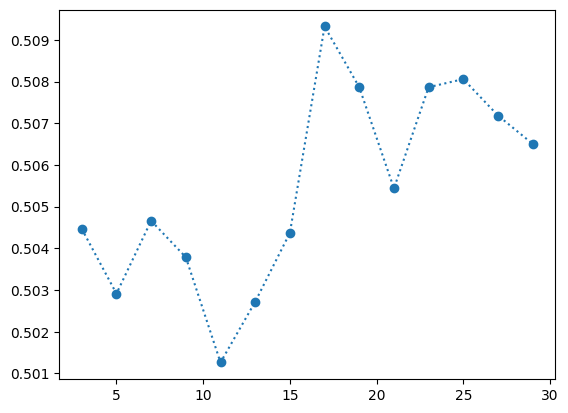

In [27]:
plt.plot(kRange, accuracies, 'o:')

### Árvore de Decisão

In [28]:
def DecisionTreeTrain(X_train,X_test, y_train,y_test):
    # Inicializa o classificador de árvore de decisão
    model = DecisionTreeClassifier()
    # Treina o modelo com os dados de treinamento
    model.fit(X_train, y_train)
    # Realiza a predição nos dados de teste
    y_pred = model.predict(X_test)
    # Calcula a acurácia do modelo
    accuracy = accuracy_score(y_test, y_pred)
    print("accuracy: {:.3f}%".format(accuracy*100))
    return accuracy

In [29]:
DecisionTreeTrain(X_train,X_test, y_train,y_test)

accuracy: 51.505%


0.5150514663041367

### Random Florest

In [30]:
def RandomForestTrain(X_train,X_test, y_train,y_test):
    # Inicializa o classificador de árvore de decisão
    model = RandomForestClassifier()
    # Treina o modelo com os dados de treinamento
    model.fit(X_train, y_train)
    # Realiza a predição nos dados de teste
    y_pred = model.predict(X_test)
    # Calcula a acurácia do modelo
    accuracy = accuracy_score(y_test, y_pred)
    print("accuracy: {:.3f}%".format(accuracy*100))
    return accuracy

In [31]:
RandomForestTrain(X_train,X_test, y_train,y_test)

accuracy: 51.457%


0.5145659351330355

### Regreção Logistica

In [32]:
def LogisticRegressionTrain(X_train,X_test, y_train,y_test):
    # Criar um objeto de regressão logística
    model = LogisticRegression()

    # Treinar o modelo de regressão logística usando os dados de treinamento
    model.fit(X_train, y_train)

    # Fazer previsões usando os dados de teste
    y_pred = model.predict(X_test)

    # Calcular a acurácia do modelo
    accuracy = accuracy_score(y_test, y_pred)
    print("accuracy: {:.3f}%".format(accuracy*100))
    return accuracy

In [33]:
LogisticRegressionTrain(X_train,X_test, y_train,y_test)

accuracy: 51.855%


c:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.5185472907360652

### Gradient Boosting

In [34]:
# Definir os parâmetros do modelo
xgBoostParams = {
    'objective': 'binary:logistic',  # Para classificação binária
    'eval_metric': 'logloss',
    'eta': 0.1,
    'max_depth': 3,
    'n_estimators': 100
}
def XGBoostTrain(X_train,X_test, y_train,y_test, params = xgBoostParams):
    y_train = y_train.map({1: 0, 2: 1})
    y_test = y_test.map({1: 0, 2: 1})
    # Criar o objeto do modelo de Gradient Boosting
    model = xgb.XGBClassifier(**params)

    # Treinar o modelo
    model.fit(X_train, y_train)

    # Fazer previsões usando os dados de teste
    y_pred = model.predict(X_test)

    # Calcular a acurácia do modelo
    accuracy = accuracy_score(y_test, y_pred)
    print("accuracy: {:.3f}%".format(accuracy*100))
    return accuracy

In [35]:
XGBoostTrain(X_train,X_test, y_train,y_test)

accuracy: 52.399%


0.5239852398523985

### Neural Network

In [36]:
def NeuralNetworkTrain(X_train, X_test, y_train, y_test, input_dim):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(input_dim,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compilar o modelo
    model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
    # Treinar o modelo
    model.fit(X_train, y_train, epochs=10, batch_size=32)
    # Fazer previsões usando os dados de teste
    y_pred = model.predict(X_test)
    y_pred = (y_pred > 0.5)  # Converter as previsões em rótulos binários
    # Calcular a acurácia do modelo
    accuracy = accuracy_score(y_test, y_pred)
    print("accuracy: {:.3f}%".format(accuracy*100))
    return accuracy

In [37]:
feature_names = df.drop(['winner'], axis=1).columns.tolist()
input_dim = len(feature_names)
NeuralNetworkTrain(X_train, X_test, y_train, y_test, input_dim)

Epoch 1/10
1288/1288 [==============================] - 2s 1ms/step - loss: -10417777.0000 - accuracy: 0.5059
Epoch 2/10
1288/1288 [==============================] - 2s 1ms/step - loss: -131106048.0000 - accuracy: 0.5061
Epoch 3/10
1288/1288 [==============================] - 2s 1ms/step - loss: -468035008.0000 - accuracy: 0.5061
Epoch 4/10
1288/1288 [==============================] - 2s 1ms/step - loss: -1066637184.0000 - accuracy: 0.5061
Epoch 5/10
1288/1288 [==============================] - 2s 1ms/step - loss: -1963185408.0000 - accuracy: 0.5061
Epoch 6/10
1288/1288 [==============================] - 2s 1ms/step - loss: -3192242176.0000 - accuracy: 0.5061
Epoch 7/10
1288/1288 [==============================] - 2s 1ms/step - loss: -4790603776.0000 - accuracy: 0.5061
Epoch 8/10
1288/1288 [==============================] - 2s 1ms/step - loss: -6796626432.0000 - accuracy: 0.5061
Epoch 9/10
1288/1288 [==============================] - 2s 1ms/step - loss: -9248751616.0000 - accuracy: 0.5

0.5079627112060594